In [14]:
import pandas as pd
from darts import TimeSeries
from darts.models import NHiTSModel
from darts.metrics import mse, rmse, r2_score, mae, smape, wmape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, facet_grid
)
import json


torch.set_float32_matmul_precision('medium')


In [15]:
target_columns = [
    'Temperature','Humidity','Wind_Speed_kmh','Soil_Moisture','Soil_Temperature','Wind_Dir_Sin','Wind_Dir_Cos','Precipitation_accumulated'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [16]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [17]:
best_mse = float('inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

# Listas para armazenar dados de todos os folds
all_forecasts = []
all_val_scaled = []
all_scalers = []
all_metrics_dfs = []
all_mse_scores = []
all_train_scaled = []
all_metrics_horizon = []

tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = NHiTSModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=60,
        output_chunk_length=24,
        n_epochs=100,
        batch_size=208,
        dropout=0.35,
        num_blocks=3,
        num_layers=5,
        num_stacks=3,
        layer_widths=32,
        activation="ReLU",
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.L1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.00013929636378647018, "weight_decay": 2.784544338277865e-05},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )

    model.load_from_checkpoint(f"model_{fold+1}/", best=True)

    metrics_per_horizon = []
    for i in [1,4,8,12,16,20,24]:
        forecasts = model.historical_forecasts(
            val_scaled,
            forecast_horizon=i,
            stride=1,
            retrain=False,
            verbose=False,
            last_points_only=True,
        )

        forecasts_t = scaler.inverse_transform(forecasts)
        s = scaler.inverse_transform(val_scaled)
        metrics = {}
        print("Iniciando a verificação das séries temporais para constância...")
        try:
            for target in target_columns:
                metrics[target] = {
                    'MSE': mse(s[target], forecasts_t[target]),
                    'RMSE': rmse(s[target], forecasts_t[target]),
                    'MAE': mae(s[target], forecasts_t[target]),
                    'R2': r2_score(s[target], forecasts_t[target]),
                    'SMAPE': smape(s[target], forecasts_t[target]),
                    'WMAPE': wmape(s[target], forecasts_t[target]),
                }
            metrics_df = pd.DataFrame(metrics).T
            print("\nMétricas de performance:")
            print(metrics_df)
            metrics_per_horizon.append(metrics_df)
        except Exception as e:
            print(e)

    mse_geral = mse(s, forecasts_t)
    print(f"O MSE desse fold foi {mse_geral}")

    # Armazenar dados deste fold
    all_forecasts.append(forecasts)
    all_val_scaled.append(val_scaled)
    all_scalers.append(scaler)
    all_metrics_dfs.append(metrics_df)
    all_metrics_horizon.append(metrics_per_horizon)
    all_mse_scores.append(mse_geral)
    all_train_scaled.append(train_scaled)

    # Ainda mantemos o melhor fold para referência (agora baseado no MSE)
    if best_mse > mse_geral:
        best_mse = mse_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold (baseado no menor MSE) foi {best_fold}")

# Calcular a média dos R2 e MSE de todos os folds
avg_mse = sum(all_mse_scores) / len(all_mse_scores)
print(f"A média dos MSE de todos os folds foi {avg_mse:.4f}")

avg_metrics = {}
metric_names = ['MSE', 'RMSE', 'MAE', 'R2', 'SMAPE', 'WMAPE'] # Definir nomes das métricas

for target in target_columns:
    avg_metrics[target] = {} # Inicializar dicionário para o target atual
    for metric_name in metric_names:
        metric_values_for_fold = []
        # Coletar todos os valores válidos da métrica para o target atual em todos os folds
        for df_fold in all_metrics_dfs:
            # Verificar se o target existe como índice e a métrica como coluna no df_fold
            if target in df_fold.index and metric_name in df_fold.columns:
                value = df_fold.loc[target, metric_name]
                # Adicionar à lista apenas se não for NaN
                if pd.notna(value):
                    metric_values_for_fold.append(value)
        
        # Calcular a média apenas se houver valores válidos
        if metric_values_for_fold:
            avg_metrics[target][metric_name] = sum(metric_values_for_fold) / len(metric_values_for_fold)
        else:
            # Caso contrário, registrar NaN (ou outro valor padrão, se preferir)
            avg_metrics[target][metric_name] = float('nan')

avg_metrics_df = pd.DataFrame(avg_metrics).T
print("\nMétricas médias de performance de todos os folds:")
print(avg_metrics_df)


with open('all_metrics_horizon.json', 'w') as f:
    all_metrics_horizon_dict = [
        [df.to_dict() for df in fold_metrics] for fold_metrics in all_metrics_horizon
    ]
    json.dump(all_metrics_horizon_dict, f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

print("\nUsando a média dos folds para análise...")


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 7.047
Metric val_loss improved by 0.049 >= min_delta = 0.001. New best score: 6.998
Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 6.969
Monitored metric val_loss did not improve in the last 10 records. Best score: 6.969. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE          RMSE          MAE  \
Temperature                2.437749e+04    156.132925    85.426175   
Humidity                   1.044720e+05    323.221256   195.905488   
Wind_Speed_kmh             1.003572e+03     31.679197    17.708658   
Soil_Moisture              1.245666e+08  11160.942133  6357.554438   
Soil_Temperature           3.650462e+04    191.061833   104.518934   
Wind_Dir_Sin               6.749778e+01      8.215703     4.665186   
Wind_Dir_Cos               7.109052e+01      8.431520     4.729569   
Precipitation_accumulated  5.402145e+04    232.425153   128.481726   

                                    R2       SMAPE        WMAPE  
Temperature                -525.368935   76.746813   516.328495  
Humidity                   -344.017932   97.479771   257.502921  
Wind_Speed_kmh            -2088.225921  120.589304  1920.395138  
Soil_Moisture  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                2.618320e+04   161.812234    89.205233   
Humidity                   1.186652e+05   344.478084   211.702263   
Wind_Speed_kmh             8.254181e+02    28.730090    15.500834   
Soil_Moisture              9.803682e+07  9901.354246  5683.639018   
Soil_Temperature           2.450708e+04   156.547378    86.347553   
Wind_Dir_Sin               3.554706e+01     5.962136     3.429569   
Wind_Dir_Cos               5.600182e+01     7.483436     4.348933   
Precipitation_accumulated  5.412000e+04   232.637053   128.129224   

                                    R2       SMAPE        WMAPE  
Temperature                -563.435463   78.325552   539.432276  
Humidity                   -390.013099  109.250351   278.251117  
Wind_Speed_kmh            -1713.725171   95.509693  1681.095925  
Soil_Moisture           

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE         R2  \
Temperature                3.857716e+03    62.110517    36.285782 -81.931008   
Humidity                   1.120145e+04   105.836925    69.244368 -35.800484   
Wind_Speed_kmh             1.121851e+01     3.349405     2.111709 -22.266293   
Soil_Moisture              2.173975e+06  1474.440482  1324.982066  -0.764703   
Soil_Temperature           1.288670e+03    35.898053    23.728040 -21.496330   
Wind_Dir_Sin               2.776713e+00     1.666347     1.183365  -6.688556   
Wind_Dir_Cos               2.829914e+00     1.682235     1.187841  -4.002052   
Precipitation_accumulated  6.114978e+04   247.284822   136.928009  -0.458569   

                                SMAPE       WMAPE  
Temperature                 69.201788  219.461559  
Humidity                    52.371238   91.014497  
Wind_Speed_kmh              90.64

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE          RMSE          MAE  \
Temperature                2.690037e+04    164.013330    92.101741   
Humidity                   2.386705e+05    488.539174   286.828503   
Wind_Speed_kmh             2.671748e+03     51.688956    27.962109   
Soil_Moisture              2.704923e+08  16446.649549  9114.565847   
Soil_Temperature           6.279573e+04    250.590760   135.668266   
Wind_Dir_Sin               8.463649e+01      9.199809     5.117394   
Wind_Dir_Cos               4.692211e+01      6.849971     3.977323   
Precipitation_accumulated  5.593708e+04    236.510207   131.322541   

                                    R2       SMAPE        WMAPE  
Temperature                -575.959305  106.797382   556.703828  
Humidity                   -781.247617  116.250413   377.126080  
Wind_Speed_kmh            -5531.787980  115.350346  3027.064131  
Soil_Moisture  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE          RMSE          MAE  \
Temperature                1.520737e+04    123.318156    67.916154   
Humidity                   1.310973e+05    362.073631   198.411435   
Wind_Speed_kmh             9.185929e+02     30.308298    16.049821   
Soil_Moisture              1.039828e+08  10197.195344  5892.505812   
Soil_Temperature           1.640043e+04    128.064173    74.100102   
Wind_Dir_Sin               1.962120e+01      4.429582     2.616533   
Wind_Dir_Cos               1.203307e+01      3.468871     2.072378   
Precipitation_accumulated  5.955574e+04    244.040453   136.602951   

                                    R2       SMAPE        WMAPE  
Temperature                -324.534385   77.812497   410.206829  
Humidity                   -427.880533   61.434894   260.986719  
Wind_Speed_kmh            -1898.609564   90.455286  1735.298045  
Soil_Moisture  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE         R2  \
Temperature                1.557373e+03    39.463566    24.455596 -32.278640   
Humidity                   2.076093e+03    45.564161    36.407219  -5.783925   
Wind_Speed_kmh             4.599485e+00     2.144641     1.712161  -8.494832   
Soil_Moisture              9.713112e+06  3116.586588  2124.278013  -6.865934   
Soil_Temperature           5.679090e+03    75.359737    44.059219 -97.496438   
Wind_Dir_Sin               1.278815e+01     3.576053     2.377000 -34.445709   
Wind_Dir_Cos               2.654963e+01     5.152634     3.041142 -45.743807   
Precipitation_accumulated  5.761388e+04   240.028912   134.170905  -0.367144   

                                SMAPE       WMAPE  
Temperature                 82.046271  147.599158  
Humidity                    66.426964   47.915465  
Wind_Speed_kmh              99.37

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE          R2  \
Temperature                3.404183e+03    58.345378    33.536020  -71.721561   
Humidity                   1.162316e+03    34.092750    27.941733   -2.789329   
Wind_Speed_kmh             2.276410e+02    15.087778     9.103902 -468.617214   
Soil_Moisture              4.584648e+06  2141.179098  1569.484367   -2.707130   
Soil_Temperature           9.843768e+01     9.921577     8.244606   -0.714612   
Wind_Dir_Sin               5.441244e+00     2.332648     1.504914  -14.056971   
Wind_Dir_Cos               5.645616e-01     0.751373     0.589374    0.006763   
Precipitation_accumulated  6.059239e+04   246.155223   137.612607   -0.435349   

                                SMAPE       WMAPE  
Temperature                 67.526531  202.611228  
Humidity                    46.275043   36.768446  
Wind_Speed_kmh          

Metric val_loss improved. New best score: 0.494
Metric val_loss improved by 0.027 >= min_delta = 0.001. New best score: 0.468
Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.444
Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.423
Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.410
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.401
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.395
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.392
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.390
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.388
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.386
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.384
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.383
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                   11.505662    3.392000    2.711043 -4.319973e-01   
Humidity                      29.676973    5.447658    4.429461 -4.355481e-01   
Wind_Speed_kmh                 0.107760    0.328269    0.302533 -1.209881e+07   
Soil_Moisture              85045.388975  291.625426  280.889366 -1.416863e+01   
Soil_Temperature              11.400327    3.376437    2.618113 -3.099269e-01   
Wind_Dir_Sin                   0.121238    0.348193    0.332108          -inf   
Wind_Dir_Cos                   0.182947    0.427724    0.399181          -inf   
Precipitation_accumulated   3618.538875   60.154292   48.982468 -7.529810e+05   

                                SMAPE         WMAPE  
Temperature                 17.729481  1.743741e+01  
Humidity                     5.288032  5.153113e+00  
Wind_Speed_kmh    

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    9.849444    3.138382    2.575069 -2.310313e-01   
Humidity                      16.217605    4.027109    3.317774  2.170205e-01   
Wind_Speed_kmh                 0.156500    0.395600    0.366735 -1.753126e+07   
Soil_Moisture              95603.520499  309.198190  287.583173 -1.613730e+01   
Soil_Temperature              12.570153    3.545441    2.707204 -4.504079e-01   
Wind_Dir_Sin                   0.061497    0.247987    0.232739          -inf   
Wind_Dir_Cos                   0.111709    0.334228    0.314782          -inf   
Precipitation_accumulated   2318.755333   48.153456   38.312667 -5.142807e+05   

                                SMAPE         WMAPE  
Temperature                 16.789290  1.657439e+01  
Humidity                     3.903512  3.859985e+00  
Wind_Speed_kmh    

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    6.534005    2.556170    2.173794  1.781887e-01   
Humidity                      13.010792    3.607048    2.930604  3.736495e-01   
Wind_Speed_kmh                 0.043435    0.208410    0.166264 -4.850884e+06   
Soil_Moisture              42023.569470  204.996511  192.832413 -6.588590e+00   
Soil_Temperature              14.070592    3.751079    2.918053 -6.326259e-01   
Wind_Dir_Sin                   0.053360    0.230997    0.223307          -inf   
Wind_Dir_Cos                   0.140496    0.374828    0.354844          -inf   
Precipitation_accumulated   2657.518957   51.551130   40.918779 -6.468197e+05   

                                SMAPE         WMAPE  
Temperature                 14.127118  1.400513e+01  
Humidity                     3.416331  3.409475e+00  
Wind_Speed_kmh    

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    7.905795    2.811725    2.322329 -8.671839e-04   
Humidity                      19.751230    4.444236    3.637887  5.070709e-02   
Wind_Speed_kmh                 0.107722    0.328210    0.304251 -1.199412e+07   
Soil_Moisture              27726.327911  166.512246  153.597634 -4.046173e+00   
Soil_Temperature              10.317071    3.212020    2.439174 -2.038170e-01   
Wind_Dir_Sin                   0.082958    0.288024    0.281389          -inf   
Wind_Dir_Cos                   0.247667    0.497662    0.457952          -inf   
Precipitation_accumulated   3358.439352   57.952044   46.594436 -9.068324e+05   

                                SMAPE         WMAPE  
Temperature                 15.087416  1.497676e+01  
Humidity                     4.310249  4.231886e+00  
Wind_Speed_kmh    

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    6.135236    2.476941    2.128680  2.188153e-01   
Humidity                      13.116760    3.621707    3.004713  3.707199e-01   
Wind_Speed_kmh                 0.036546    0.191170    0.157361 -4.056791e+06   
Soil_Moisture              71858.533436  268.064420  257.690489 -1.218619e+01   
Soil_Temperature               6.344113    2.518752    1.979725  2.558852e-01   
Wind_Dir_Sin                   0.089487    0.299144    0.288867          -inf   
Wind_Dir_Cos                   0.185227    0.430380    0.392719          -inf   
Precipitation_accumulated   3718.205165   60.977087   48.481826 -1.129007e+06   

                                SMAPE         WMAPE  
Temperature                 13.872542  1.374079e+01  
Humidity                     3.524050  3.494967e+00  
Wind_Speed_kmh    

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    4.822609    2.196044    1.940886  3.828250e-01   
Humidity                      12.323943    3.510547    2.922639  4.099517e-01   
Wind_Speed_kmh                 0.121315    0.348303    0.313215 -1.342545e+07   
Soil_Moisture              83920.041462  289.689560  259.075730 -1.453468e+01   
Soil_Temperature               6.050123    2.459700    2.039187  2.869063e-01   
Wind_Dir_Sin                   0.136384    0.369303    0.352890          -inf   
Wind_Dir_Cos                   0.109102    0.330305    0.301113          -inf   
Precipitation_accumulated   3712.057002   60.926653   48.909863 -1.289764e+06   

                                SMAPE         WMAPE  
Temperature                 12.714209  1.253986e+01  
Humidity                     3.415685  3.399180e+00  
Wind_Speed_kmh    

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cu

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    7.289713    2.699947    2.280996  6.287329e-02   
Humidity                      22.655007    4.759728    3.886410 -8.285817e-02   
Wind_Speed_kmh                 0.212855    0.461362    0.393308 -2.348363e+07   
Soil_Moisture              60685.504573  246.344281  222.460611 -1.032959e+01   
Soil_Temperature               9.177762    3.029482    2.295794 -8.663238e-02   
Wind_Dir_Sin                   0.067635    0.260068    0.245487          -inf   
Wind_Dir_Cos                   0.088997    0.298323    0.268140          -inf   
Precipitation_accumulated   3825.261037   61.848695   49.283682 -1.556461e+06   

                                SMAPE         WMAPE  
Temperature                 15.027931  1.475012e+01  
Humidity                     4.625106  4.519599e+00  
Wind_Speed_kmh    

Metric val_loss improved. New best score: 0.468
Metric val_loss improved by 0.038 >= min_delta = 0.001. New best score: 0.430
Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 0.402
Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.378
Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.359
Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.342
Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.324
Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.303
Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.284
Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.264
Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.242
Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.228
Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.211
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    25.991944    5.098229    5.034913   -45.430493   
Humidity                       45.917136    6.776218    6.148067    -3.795801   
Wind_Speed_kmh                  0.028412    0.168558    0.144864         -inf   
Soil_Moisture              115668.221039  340.100310  307.974114    -2.319878   
Soil_Temperature               26.440959    5.142077    5.122960  -134.211556   
Wind_Dir_Sin                    0.000414    0.020350    0.014835         -inf   
Wind_Dir_Cos                    0.002307    0.048031    0.045408         -inf   
Precipitation_accumulated     174.282049   13.201593    9.786446 -4327.345088   

                                SMAPE      WMAPE  
Temperature                 42.910328  54.260797  
Humidity                     6.942695   6.750087  
Wind_Speed_kmh             

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    28.081650    5.299212    5.238507   -49.232054   
Humidity                       45.314747    6.731623    6.097540    -3.732386   
Wind_Speed_kmh                  0.023251    0.152482    0.130145         -inf   
Soil_Moisture              115298.791094  339.556757  308.676659    -2.348570   
Soil_Temperature               31.090911    5.575922    5.554788  -158.750172   
Wind_Dir_Sin                    0.000113    0.010608    0.009051         -inf   
Wind_Dir_Cos                    0.001778    0.042162    0.032841         -inf   
Precipitation_accumulated     123.805677   11.126800    9.529453 -3076.130382   

                                SMAPE      WMAPE  
Temperature                 44.258889  56.463157  
Humidity                     6.881695   6.695052  
Wind_Speed_kmh             

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    31.285936    5.593383    5.539804   -55.072828   
Humidity                       25.877022    5.086946    4.412525    -1.700933   
Wind_Speed_kmh                  0.005313    0.072888    0.055083         -inf   
Soil_Moisture              156994.119933  396.224835  360.280333    -3.628627   
Soil_Temperature               26.234983    5.122010    5.098928  -134.410123   
Wind_Dir_Sin                    0.000754    0.027454    0.023480         -inf   
Wind_Dir_Cos                    0.000934    0.030563    0.026108         -inf   
Precipitation_accumulated      96.106755    9.803405    7.888345 -2390.220477   

                                SMAPE      WMAPE  
Temperature                 46.207139  59.729303  
Humidity                     4.915951   4.845369  
Wind_Speed_kmh             

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                   27.153995    5.210949    5.152306   -47.862401   
Humidity                      33.549585    5.792200    5.089113    -2.498221   
Wind_Speed_kmh                 0.015730    0.125419    0.115363         -inf   
Soil_Moisture              91621.915302  302.691122  260.655748    -1.744179   
Soil_Temperature              21.113981    4.594995    4.559653  -108.815424   
Wind_Dir_Sin                   0.000989    0.031451    0.028583         -inf   
Wind_Dir_Cos                   0.003913    0.062555    0.061039         -inf   
Precipitation_accumulated     94.640775    9.728349    7.933698 -2356.320093   

                                SMAPE      WMAPE  
Temperature                 43.719361  55.572050  
Humidity                     5.721690   5.588799  
Wind_Speed_kmh             200.00000

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    28.736162    5.360612    5.305706   -51.050887   
Humidity                       27.062952    5.202206    4.541280    -1.818654   
Wind_Speed_kmh                  0.021858    0.147844    0.143951         -inf   
Soil_Moisture              129227.924537  359.482857  327.979861    -2.938158   
Soil_Temperature               32.060431    5.662193    5.649566  -167.771882   
Wind_Dir_Sin                    0.000330    0.018160    0.015184         -inf   
Wind_Dir_Cos                    0.002352    0.048502    0.045013         -inf   
Precipitation_accumulated     192.609815   13.878394   12.146855 -4801.946057   

                                SMAPE      WMAPE  
Temperature                 44.742585  57.251455  
Humidity                     5.067471   4.987585  
Wind_Speed_kmh             

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    32.717806    5.719948    5.676461   -59.300686   
Humidity                       24.361029    4.935689    4.236691    -1.532538   
Wind_Speed_kmh                  0.003541    0.059508    0.042154         -inf   
Soil_Moisture              173452.606368  416.476418  389.098687    -4.387064   
Soil_Temperature               21.976116    4.687869    4.659411  -117.543362   
Wind_Dir_Sin                    0.001232    0.035095    0.028829         -inf   
Wind_Dir_Cos                    0.003641    0.060338    0.050796         -inf   
Precipitation_accumulated     124.798487   11.171324    9.225940 -3114.604987   

                                SMAPE      WMAPE  
Temperature                 47.137256  61.290485  
Humidity                     4.719518   4.653364  
Wind_Speed_kmh             

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    33.690799    5.804378    5.751292   -61.511255   
Humidity                       19.951898    4.466755    3.675019    -1.069912   
Wind_Speed_kmh                  0.036886    0.192057    0.175912         -inf   
Soil_Moisture              176522.378482  420.145663  390.742751    -4.530857   
Soil_Temperature               30.309989    5.505451    5.483521  -164.176261   
Wind_Dir_Sin                    0.000134    0.011586    0.009874         -inf   
Wind_Dir_Cos                    0.001160    0.034064    0.027920         -inf   
Precipitation_accumulated     115.241667   10.735067    8.948086 -2879.457065   

                                SMAPE      WMAPE  
Temperature                 47.588414  62.125400  
Humidity                     4.088340   4.036694  
Wind_Speed_kmh             

Metric val_loss improved. New best score: 0.437
Metric val_loss improved by 0.053 >= min_delta = 0.001. New best score: 0.384
Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.345
Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 0.314
Metric val_loss improved by 0.027 >= min_delta = 0.001. New best score: 0.287
Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.264
Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.244
Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.225
Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.210
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.202
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.191
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.189
Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.182
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE           R2  \
Temperature                3.121671e+01     5.587192    5.022497    -4.909376   
Humidity                   1.561067e+02    12.494267   10.842479    -0.855749   
Wind_Speed_kmh             1.179950e+00     1.086255    0.622458    -0.299837   
Soil_Moisture              1.314155e+06  1146.365992  789.669629     0.045081   
Soil_Temperature           4.032428e+01     6.350140    5.659780    -5.784316   
Wind_Dir_Sin               3.174924e-01     0.563465    0.393921    -0.169088   
Wind_Dir_Cos               4.519011e-01     0.672236    0.418091     0.038210   
Precipitation_accumulated  4.106585e+03    64.082645   44.253843 -3495.327706   

                                SMAPE       WMAPE  
Temperature                 66.902706   89.148607  
Humidity                    12.761068   12.875261  
Wind_Speed_kmh          

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE           R2  \
Temperature                3.231975e+01     5.685046    5.087724    -5.121971   
Humidity                   1.493876e+02    12.222420   10.569772    -0.772171   
Wind_Speed_kmh             1.164042e+00     1.078908    0.599800    -0.280089   
Soil_Moisture              1.224664e+06  1106.645475  783.804266     0.111144   
Soil_Temperature           4.806945e+01     6.933214    6.253572    -7.101814   
Wind_Dir_Sin               3.103644e-01     0.557104    0.389955    -0.140480   
Wind_Dir_Cos               5.508991e-01     0.742226    0.443622    -0.171338   
Precipitation_accumulated  2.249585e+03    47.429794   29.989031 -1917.372051   

                                SMAPE       WMAPE  
Temperature                 67.268891   90.399954  
Humidity                    12.434760   12.550574  
Wind_Speed_kmh          

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE           R2  \
Temperature                3.826721e+01     6.186049    5.587401    -6.243114   
Humidity                   1.374351e+02    11.723272   10.554374    -0.625695   
Wind_Speed_kmh             1.108039e+00     1.052634    0.557618    -0.215683   
Soil_Moisture              1.291382e+06  1136.389885  828.080456     0.064166   
Soil_Temperature           3.406052e+01     5.836139    5.225566    -4.753675   
Wind_Dir_Sin               3.176934e-01     0.563643    0.401379    -0.164190   
Wind_Dir_Cos               5.152060e-01     0.717779    0.437196    -0.094016   
Precipitation_accumulated  2.429699e+03    49.291977   30.625765 -2075.508431   

                                SMAPE       WMAPE  
Temperature                 70.949429   99.383824  
Humidity                    12.329354   12.531362  
Wind_Speed_kmh          

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE           R2  \
Temperature                2.904202e+01     5.389065    4.825656    -4.489382   
Humidity                   1.592776e+02    12.620523   10.876759    -0.878578   
Wind_Speed_kmh             1.103072e+00     1.050272    0.544663    -0.207426   
Soil_Moisture              1.395266e+06  1181.213728  799.471062    -0.009551   
Soil_Temperature           3.531457e+01     5.942606    5.262734    -4.977834   
Wind_Dir_Sin               3.200646e-01     0.565743    0.401779    -0.169633   
Wind_Dir_Cos               4.873144e-01     0.698079    0.429749    -0.033443   
Precipitation_accumulated  2.614191e+03    51.129163   31.911985 -2238.191750   

                                SMAPE       WMAPE  
Temperature                 65.647791   85.912662  
Humidity                    12.806033   12.913265  
Wind_Speed_kmh          

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE           R2  \
Temperature                3.443536e+01     5.868165    5.305472    -5.497387   
Humidity                   1.360834e+02    11.665477   10.667258    -0.600321   
Wind_Speed_kmh             1.140405e+00     1.067897    0.560192    -0.245391   
Soil_Moisture              1.302056e+06  1141.076750  815.724425     0.059376   
Soil_Temperature           5.241548e+01     7.239854    6.535128    -7.889675   
Wind_Dir_Sin               3.134617e-01     0.559877    0.394188    -0.142325   
Wind_Dir_Cos               4.629361e-01     0.680394    0.428450     0.019529   
Precipitation_accumulated  3.551636e+03    59.595607   37.791272 -3048.140093   

                                SMAPE       WMAPE  
Temperature                 69.231103   94.530914  
Humidity                    12.434166   12.663697  
Wind_Speed_kmh          

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE           R2  \
Temperature                4.326348e+01     6.577498    6.024540    -7.144100   
Humidity                   1.360748e+02    11.665112   10.619271    -0.595761   
Wind_Speed_kmh             9.787946e-01     0.989340    0.468795    -0.066415   
Soil_Moisture              1.086279e+06  1042.247230  792.625240     0.216494   
Soil_Temperature           4.109136e+01     6.410254    5.763879    -5.979572   
Wind_Dir_Sin               3.235034e-01     0.568774    0.400459    -0.175639   
Wind_Dir_Cos               4.853478e-01     0.696669    0.430954    -0.026610   
Precipitation_accumulated  3.147580e+03    56.103300   34.741995 -2707.590892   

                                SMAPE       WMAPE  
Temperature                 74.339529  107.407525  
Humidity                    12.379682   12.605478  
Wind_Speed_kmh          

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE           R2  \
Temperature                4.079570e+01     6.387151    5.822581    -6.665280   
Humidity                   1.473876e+02    12.140331   11.003030    -0.723800   
Wind_Speed_kmh             7.062240e-01     0.840371    0.466643     0.232351   
Soil_Moisture              1.157777e+06  1076.000490  830.674753     0.166235   
Soil_Temperature           5.665723e+01     7.527100    6.828654    -8.635969   
Wind_Dir_Sin               3.022690e-01     0.549790    0.376752    -0.095406   
Wind_Dir_Cos               5.833107e-01     0.763748    0.462075    -0.232233   
Precipitation_accumulated  2.753572e+03    52.474492   32.774860 -2374.220926   

                                SMAPE       WMAPE  
Temperature                 72.997984  103.881143  
Humidity                    12.850056   13.059540  
Wind_Speed_kmh          

Metric val_loss improved. New best score: 0.440
Metric val_loss improved by 0.075 >= min_delta = 0.001. New best score: 0.365
Metric val_loss improved by 0.042 >= min_delta = 0.001. New best score: 0.322
Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.299
Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.283
Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.269
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.259
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.255
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.252
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.250
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.249
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.247
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.246
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    40.069116    6.330017    4.809196    -0.432610   
Humidity                      142.014836   11.916998   10.238699     0.091018   
Wind_Speed_kmh                  1.838893    1.356058    1.045234    -0.442273   
Soil_Moisture              624153.874939  790.034097  782.627284   -99.305301   
Soil_Temperature               27.832407    5.275643    4.280068    -1.105869   
Wind_Dir_Sin                    0.550917    0.742238    0.677208    -0.001059   
Wind_Dir_Cos                    0.536073    0.732170    0.636193    -0.518905   
Precipitation_accumulated    8329.277330   91.264875   90.305465 -5313.398631   

                                SMAPE       WMAPE  
Temperature                 53.759020   47.958874  
Humidity                    12.164619   11.910104  
Wind_Speed_kmh          

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    37.928053    6.158576    4.662915    -0.363737   
Humidity                      143.795347   11.991470   10.384525     0.081129   
Wind_Speed_kmh                  1.824099    1.350592    1.042257    -0.429735   
Soil_Moisture              639522.049077  799.701225  793.068544  -101.859080   
Soil_Temperature               20.928438    4.574761    3.577085    -0.595369   
Wind_Dir_Sin                    0.550731    0.742112    0.671611    -0.000877   
Wind_Dir_Cos                    0.548906    0.740882    0.643905    -0.555349   
Precipitation_accumulated    5696.087525   75.472429   74.892030 -3670.178685   

                                SMAPE       WMAPE  
Temperature                 51.516050   46.401368  
Humidity                    12.329226   12.081667  
Wind_Speed_kmh          

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    32.412038    5.693157    4.379932    -0.164338   
Humidity                      155.295068   12.461744   10.568811     0.006790   
Wind_Speed_kmh                  1.933649    1.390557    1.067008    -0.514049   
Soil_Moisture              966234.465399  982.972261  976.707390  -154.852976   
Soil_Temperature               16.223314    4.027818    3.018534    -0.245737   
Wind_Dir_Sin                    0.551603    0.742700    0.667533    -0.002402   
Wind_Dir_Cos                    0.519920    0.721055    0.627854    -0.471499   
Precipitation_accumulated    8483.247362   92.104546   91.463273 -5542.371083   

                                SMAPE       WMAPE  
Temperature                 47.827402   43.535733  
Humidity                    12.537086   12.290294  
Wind_Speed_kmh          

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    38.674171    6.218856    4.750931    -0.385169   
Humidity                      137.953978   11.745381   10.230631     0.113590   
Wind_Speed_kmh                  2.284566    1.511478    1.152108    -0.796599   
Soil_Moisture              673651.354888  820.762667  812.582375  -107.943682   
Soil_Temperature               19.082720    4.368377    3.317537    -0.465038   
Wind_Dir_Sin                    0.562843    0.750229    0.691866    -0.022540   
Wind_Dir_Cos                    0.514993    0.717630    0.625014    -0.458206   
Precipitation_accumulated    8258.453245   90.876032   90.099995 -5472.434394   

                                SMAPE       WMAPE  
Temperature                 52.517214   47.214491  
Humidity                    12.138417   11.888701  
Wind_Speed_kmh          

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    35.829240    5.985753    4.571600    -0.282628   
Humidity                      152.714429   12.357768   10.595624     0.018237   
Wind_Speed_kmh                  1.726391    1.313922    1.015294    -0.356002   
Soil_Moisture              673143.056185  820.452958  813.276784  -107.959828   
Soil_Temperature               25.855418    5.084822    4.100762    -0.988227   
Wind_Dir_Sin                    0.559531    0.748018    0.687720    -0.014213   
Wind_Dir_Cos                    0.545688    0.738707    0.641965    -0.549531   
Precipitation_accumulated    8771.071376   93.653998   92.692470 -5897.435275   

                                SMAPE       WMAPE  
Temperature                 50.122689   45.369553  
Humidity                    12.552669   12.307173  
Wind_Speed_kmh          

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    30.721261    5.542676    4.265733    -0.103987   
Humidity                      155.658360   12.476312   10.603853     0.001975   
Wind_Speed_kmh                  1.835282    1.354726    1.039438    -0.438359   
Soil_Moisture              930637.316394  964.695453  959.804227  -149.605781   
Soil_Temperature               16.373850    4.046461    3.080385    -0.266694   
Wind_Dir_Sin                    0.559270    0.747843    0.666609    -0.012979   
Wind_Dir_Cos                    0.526943    0.725909    0.632110    -0.497993   
Precipitation_accumulated    7906.979839   88.921200   88.115855 -5396.578659   

                                SMAPE       WMAPE  
Temperature                 46.262468   42.232847  
Humidity                    12.563247   12.314953  
Wind_Speed_kmh          

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    33.934360    5.825321    4.435403    -0.229294   
Humidity                      154.359724   12.424159   10.533019     0.013236   
Wind_Speed_kmh                  2.008123    1.417082    1.079383    -0.579829   
Soil_Moisture              449657.385443  670.564975  663.151795   -71.825631   
Soil_Temperature               12.388732    3.519763    2.658645     0.031658   
Wind_Dir_Sin                    0.567938    0.753616    0.695927    -0.027093   
Wind_Dir_Cos                    0.473662    0.688231    0.601962    -0.352930   
Precipitation_accumulated    7393.372966   85.984725   85.065668 -5124.360948   

                                SMAPE       WMAPE  
Temperature                 47.935693   43.782572  
Humidity                    12.486771   12.233462  
Wind_Speed_kmh          

In [18]:
# Ainda carregamos o modelo do melhor fold para previsões
model.load_from_checkpoint(f"model_{best_fold}/", best=True)

NHiTSModel(output_chunk_shift=0, num_stacks=3, num_blocks=3, num_layers=5, layer_widths=32, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.35, activation=ReLU, MaxPool1d=True, model_name=model_2, input_chunk_length=60, output_chunk_length=24, n_epochs=100, batch_size=208, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7ee4d0113260>]}, loss_fn=L1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.000139296363786470

In [19]:
# Preparar dados para visualização usando a média dos folds
# Primeiro, vamos transformar os dados de cada fold
all_s_dfs = []
all_forecasts_dfs = []

for i, (val_scaled, forecasts, scaler) in enumerate(zip(all_val_scaled, all_forecasts, all_scalers)):
    # Transformar dados de validação
    s_fold = scaler.inverse_transform(val_scaled)
    s_fold_df = s_fold.to_dataframe()
    s_fold_df = s_fold_df.reset_index()
    s_fold_df['fold'] = i + 1
    all_s_dfs.append(s_fold_df)

    # Transformar previsões
    forecasts_fold = scaler.inverse_transform(forecasts)
    forecasts_fold_df = forecasts_fold.to_dataframe()
    forecasts_fold_df = forecasts_fold_df.reset_index()
    forecasts_fold_df['fold'] = i + 1
    all_forecasts_dfs.append(forecasts_fold_df)

# Combinar todos os dataframes
s_df = pd.concat(all_s_dfs)
forecasts_t_df = pd.concat(all_forecasts_dfs)

# Renomear colunas para consistência
s_df = s_df.rename(columns={"time": "Timestamp"})
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})

# Para referência, também mantemos os dados do melhor fold
s_best = best_scaler.inverse_transform(best_val_scaled)
forecasts_t_best = best_scaler.inverse_transform(best_forecasts)
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Humidity', 'Wind_Speed_kmh',
       'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos',
       'Precipitation_accumulated', 'fold'],
      dtype='object', name='component')


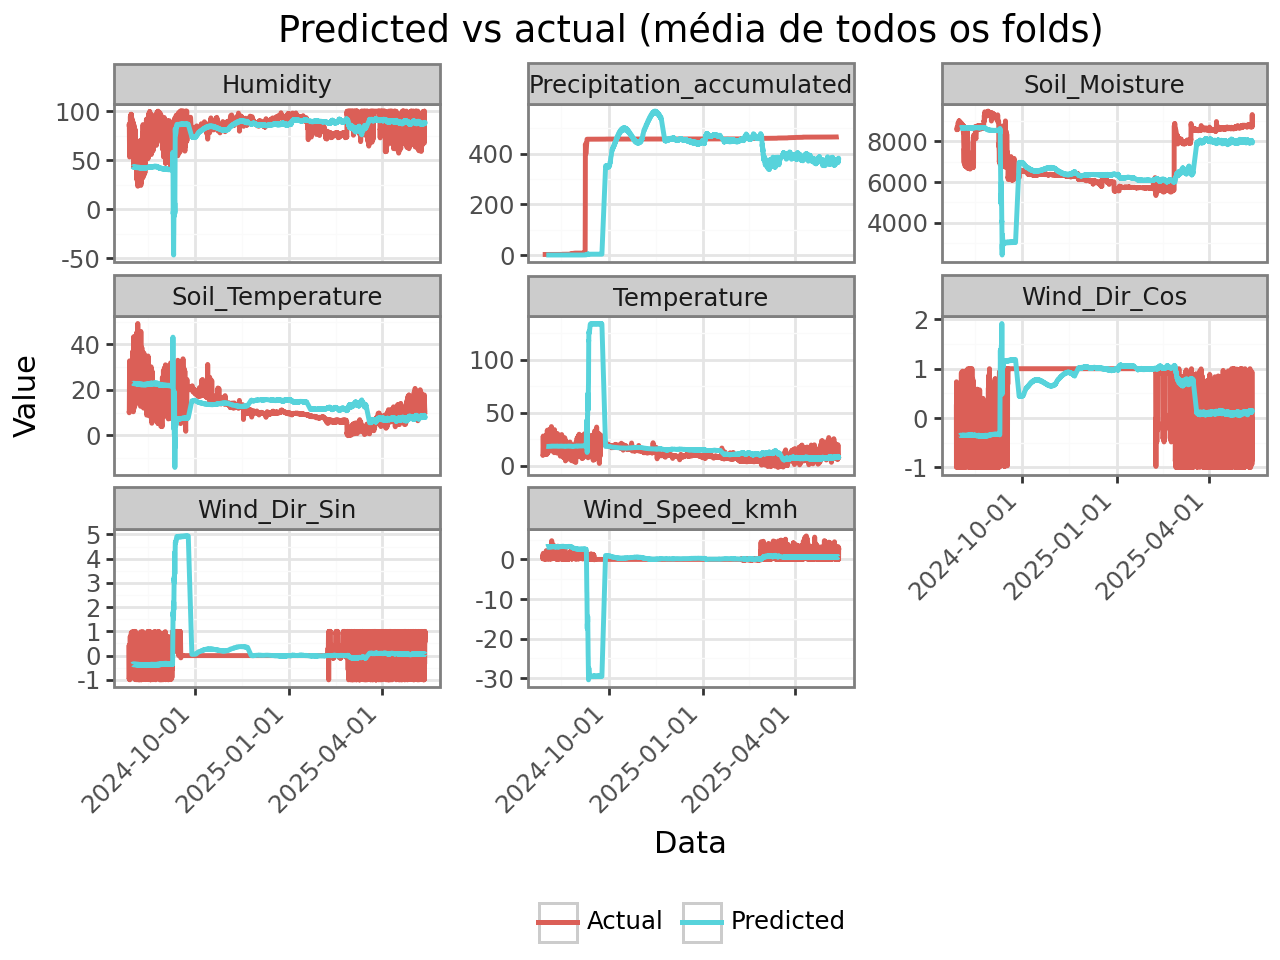

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_avg.png


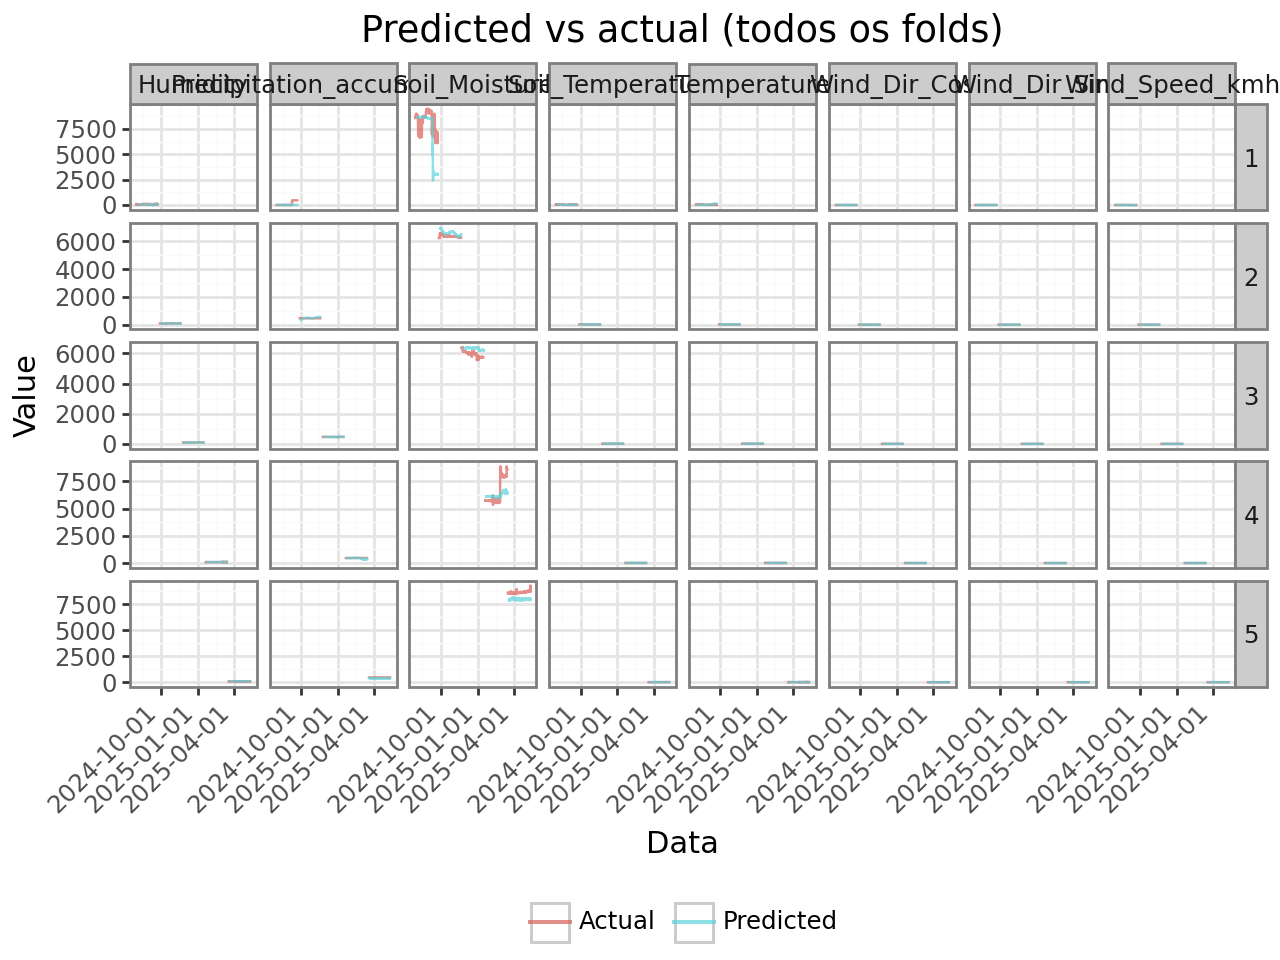

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 20 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_all_folds.png
/tmp/ipykernel_233252/688565223.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


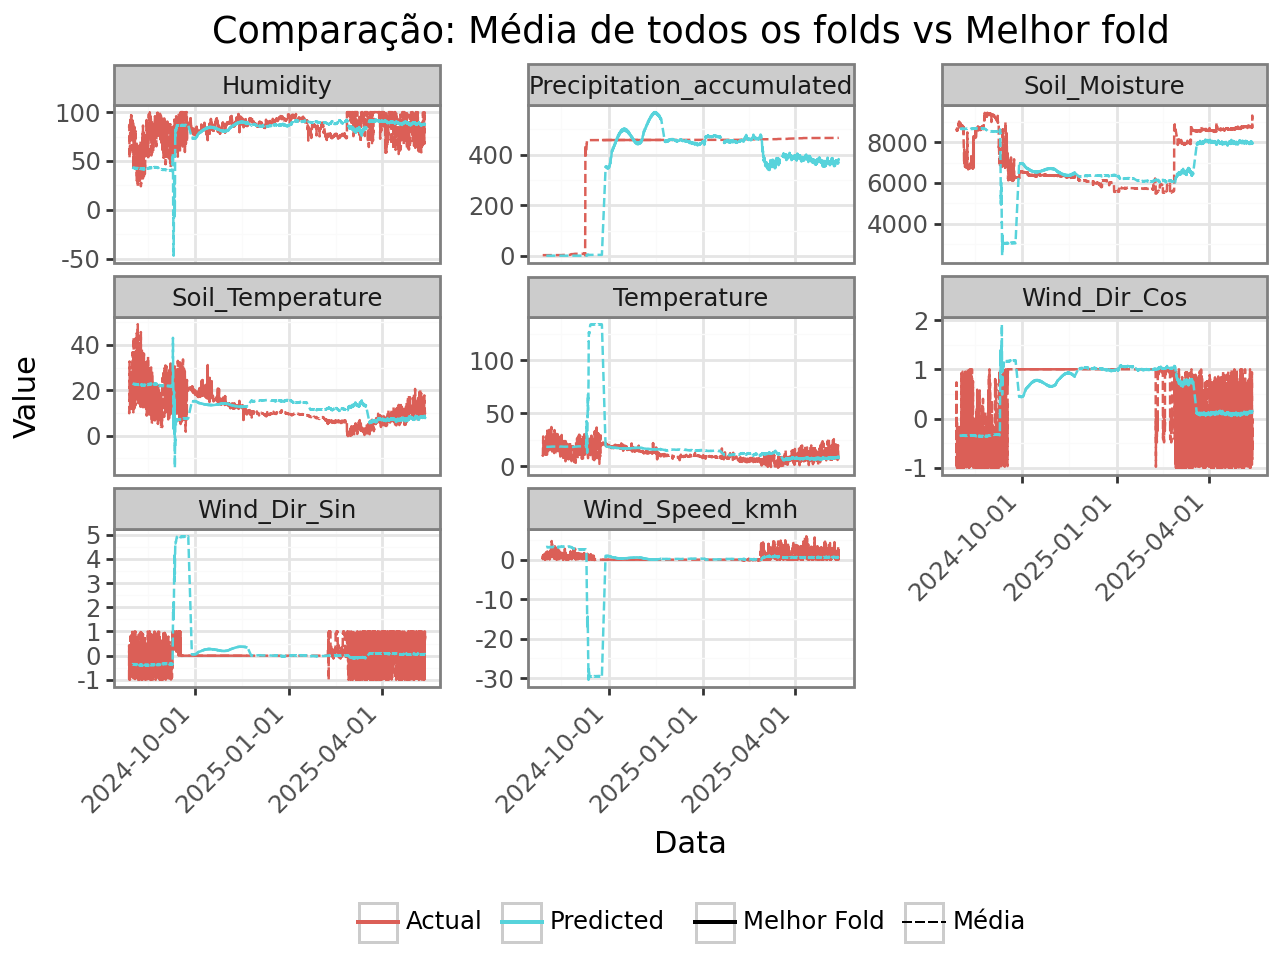

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_comparison.png


In [20]:
plot_columns = ['Timestamp', 'fold'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

# Também criar uma versão agregada (média) para cada target e timestamp
df_avg = df_combined.groupby(['Date', 'target_column', 'type']).agg({'value': 'mean'}).reset_index()
df_avg['fold'] = 'Média'

# Combinar os dados médios com os dados originais
df_all = pd.concat([df_combined, df_avg])

# Plot 1: Média de todos os folds
plot_avg = (
    ggplot(df_avg, aes(x='Date', y='value', color='type'))
    + geom_line(size=1)
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (média de todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_avg.show()
plot_avg.save('predict_actual_avg.png', width=12, height=10, dpi=300)

# Plot 2: Todos os folds separados por target
plot_all_folds = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line(alpha=0.7)
    + facet_grid('fold ~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        strip_text_y=element_text(angle=0)
    )
)
plot_all_folds.show()
plot_all_folds.save('predict_actual_all_folds.png', width=15, height=20, dpi=300)

# Plot 3: Comparação da média com o melhor fold
# Primeiro, preparar os dados do melhor fold
best_fold_data = df_combined[df_combined['fold'] == best_fold]
best_fold_data['fold'] = 'Melhor Fold'
comparison_data = pd.concat([df_avg, best_fold_data])

plot_comparison = (
    ggplot(comparison_data, aes(x='Date', y='value', color='type', linetype='fold'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Comparação: Média de todos os folds vs Melhor fold',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_comparison.show()
plot_comparison.save('predict_actual_comparison.png', width=12, height=10, dpi=300)

In [21]:
# Salvar métricas do melhor fold
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

# Salvar todas as métricas em um único arquivo
all_metrics = {
    'average': avg_metrics_df.to_dict(),
    'best_fold': best_metrics.to_dict(),
    'all_folds': {f'fold_{i+1}': df.to_dict() for i, df in enumerate(all_metrics_dfs)}
}
with open('all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)

print("\nAnálise completa! Os resultados foram salvos usando a média de todos os folds.")



Análise completa! Os resultados foram salvos usando a média de todos os folds.
